In [ ]:

!pip install -q missingno


In [ ]:
# Step 2: Import necessary libraries
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Shape: (14304, 18)


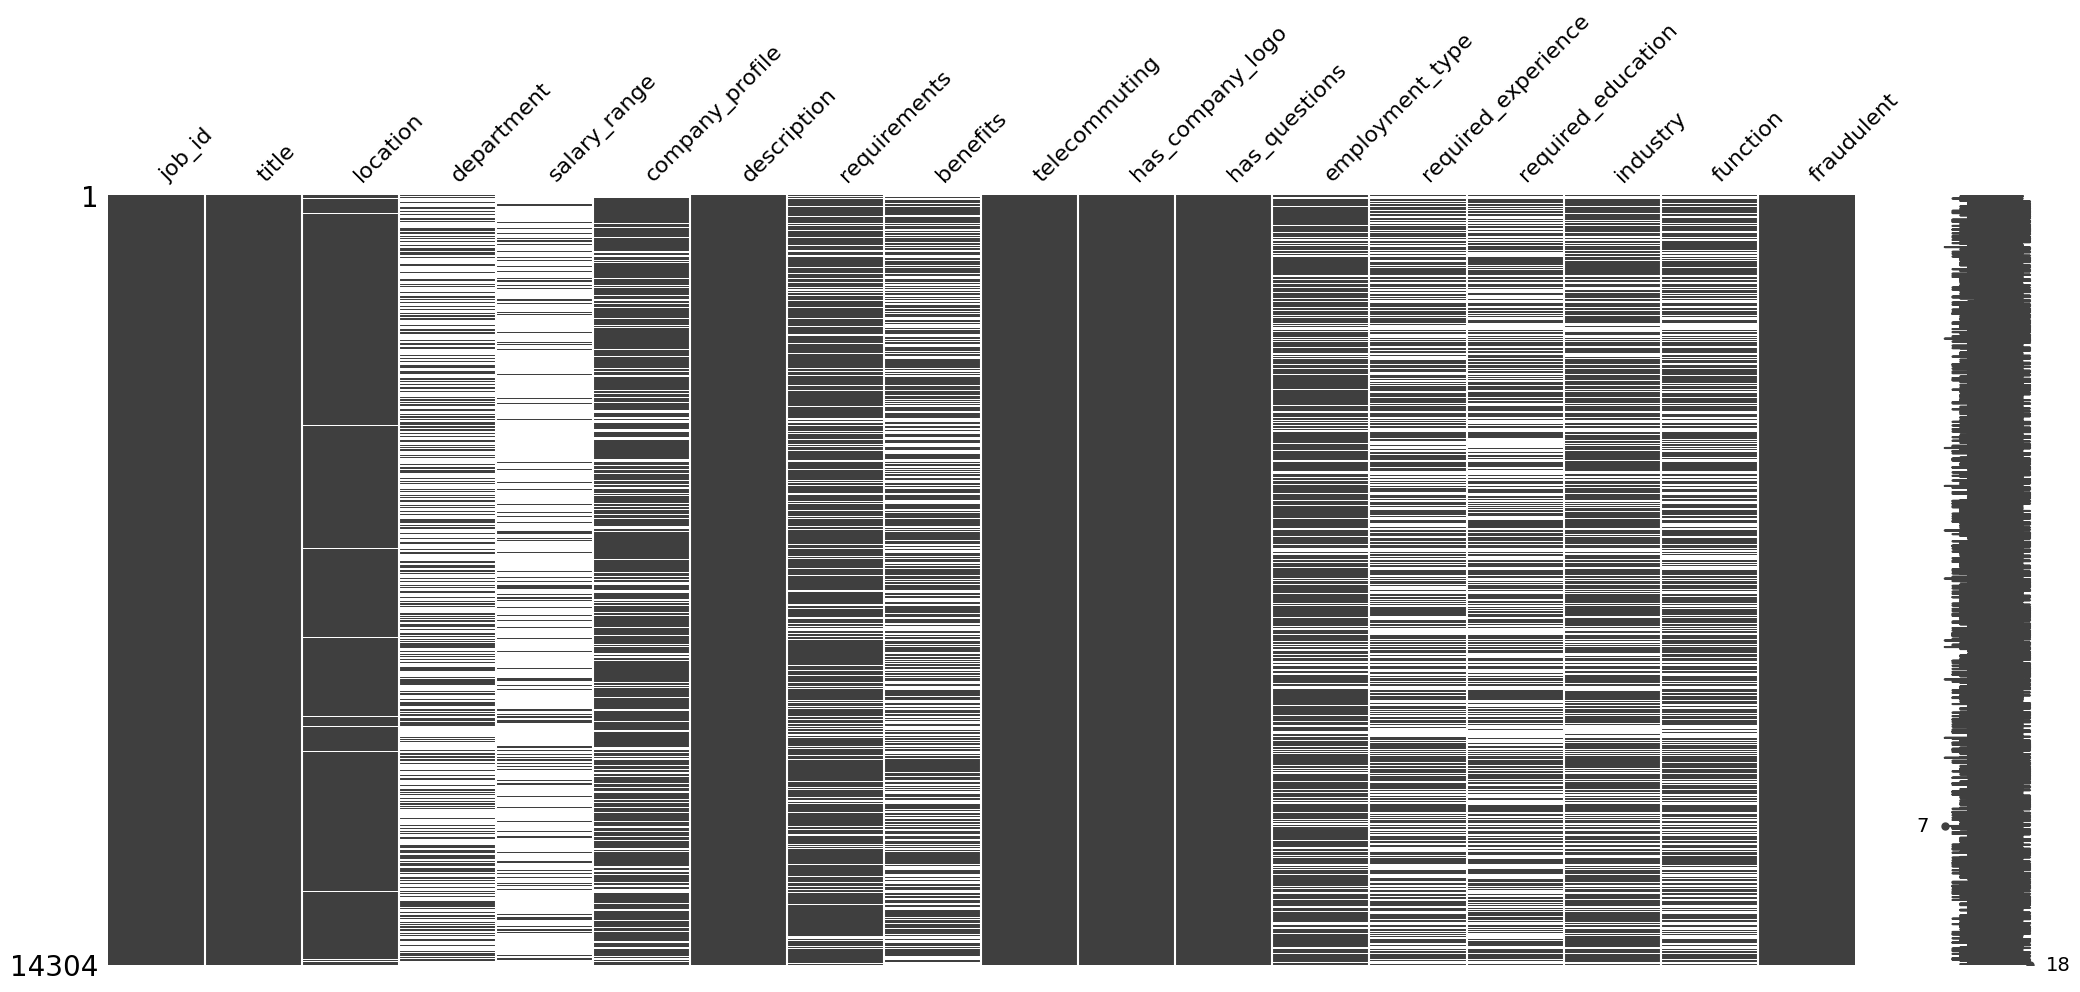

In [ ]:

file_path = '/content/drive/MyDrive/train.csv'
df = pd.read_csv(file_path)
print("Shape:", df.shape)
df.head()
# Step 5: Visualize missing values
msno.matrix(df)
plt.show()


In [ ]:
# Step 6: Drop irrelevant columns and duplicates
drop_cols = ['job_id', 'telecommuting', 'has_questions']
df.drop(columns=drop_cols, errors='ignore', inplace=True)
df.drop_duplicates(inplace=True)
print("After cleaning:", df.shape)

After cleaning: (14115, 15)


In [ ]:
# Step 7: Clean text columns
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

text_cols = ['title', 'location', 'company_profile', 'description', 'requirements', 'benefits']
for col in text_cols:
    df[col] = df[col].astype(str).apply(clean_text)


In [ ]:
# Step 8: Fill missing values in structured fields
cat_cols = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
for col in cat_cols:
    df[col] = df[col].fillna("Unknown")

num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
imp = SimpleImputer(strategy='mean')
df[num_cols] = imp.fit_transform(df[num_cols])


In [ ]:
# Step 9: Add a suspicious keyword flag
suspicious_keywords = ['wire transfer', 'western union', 'fee', 'urgent', 'credit card', 'money', 'pay to apply']

def keyword_flag(text):
    return int(any(word in text.lower() for word in suspicious_keywords))

df['suspicious_flag'] = df['description'].apply(keyword_flag)
# Step 10: Save cleaned data to Google Drive
output_path = '/content/drive/MyDrive/cleaned_train.csv'
df.to_csv(output_path, index=False)
print(f"Saved cleaned data to {output_path}")


Saved cleaned data to /content/drive/MyDrive/cleaned_train.csv


In [ ]:
# Step 1: Copy file to Colab local file system
!cp "/content/drive/MyDrive/cleaned_train.csv" "/content/cleaned_train.csv"

# Step 2: Download to your computer
from google.colab import files
files.download("/content/cleaned_train.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PHASE 2

In [ ]:
# Adjust path if needed
df = pd.read_csv('/content/drive/MyDrive/cleaned_train.csv')
df.shape
!pip install -q scikit-learn

#ML

In [ ]:
import pandas as pd
import numpy as np
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score


In [ ]:

df = pd.read_csv('/content/drive/MyDrive/cleaned_train.csv')
df.shape


(14115, 16)

In [ ]:
text_features = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df['combined_text'] = df[text_features].fillna('').agg(' '.join, axis=1)


In [ ]:
cat_cols = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
df[cat_cols] = df[cat_cols].fillna('Unknown')

le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le


In [ ]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_text = tfidf.fit_transform(df['combined_text'])

In [ ]:
X_structured = df[cat_cols + ['suspicious_flag']].reset_index(drop=True)
from scipy.sparse import hstack
X = hstack([X_text, X_structured])
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      2686
         1.0       0.97      0.50      0.66       137

    accuracy                           0.97      2823
   macro avg       0.97      0.75      0.82      2823
weighted avg       0.97      0.97      0.97      2823

F1 Score: 0.6570048309178744


In [ ]:
# Save model
with open('/content/drive/MyDrive/model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save vectorizer
with open('/content/drive/MyDrive/vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Save test set for dashboard phase
pd.DataFrame(X_test.toarray()).to_csv('/content/drive/MyDrive/X_test.csv', index=False)
pd.DataFrame(y_test).to_csv('/content/drive/MyDrive/y_test.csv', index=False)
